In [1]:
import pandas as pd
import os
import numpy as np
import datetime
import chardet
import time
from matplotlib import pyplot as plt
from collections import Counter
from itertools import combinations

In [2]:
soot_results = pd.read_csv('miningframework/output/results/execution-1/soot-results.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
loi = pd.read_csv('LOI.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

In [3]:
def get_loi(project, class_name,  method, merge_commit):

        filter_scenario = (loi['Project'] == str(project)) & (loi['Merge Commit'] == str(merge_commit)) & (loi['Class Name'] == str(class_name)) & (loi['Method or field declaration changed by the two merged branches'] == str(method))
        value_LOI = ""

        if filter_scenario.any():
            value_LOI = loi.loc[filter_scenario, 'Locally Observable Interference'].values[0]

        return value_LOI

In [4]:
info_LOI = ['project', 'class', 'method', 'merge commit']

list_values = soot_results.columns.tolist()
remove_columns = ['project', 'class', 'method', 'merge commit', 'Time']
analysis = [coluna for coluna in list_values if coluna not in remove_columns]

In [5]:
left_right_analysis = list(set([x.replace("left right ", "") for x in analysis if "left right " in x]))
analysis_name = list(set([x.replace("left right ", "").replace("right left ", "") for x in analysis]))

In [6]:
def get_name_analysis(list_name):
    names = []
    for i in list_name:
        if (i in left_right_analysis):
            names.append("left right "+i)
            names.append("right left "+i)
        else:
            names.append(i)
    return names

def get_reverse_name(lists):
    names = []
    for elem_list in lists:
        aux_list = []
        for i in elem_list:
            if "left right" in i:
                aux_list.append(i.replace("left right ", ""))
            elif ("right left " not in i):
                aux_list.append(i)
        names.append(aux_list)
    return names


In [7]:
# Lista dos elementos
elements = analysis_name
combinations_list = []
# Gerar todas as combinações possíveis de 2 a 4 elementos sem repetições
for length in range(1, len(elements) + 1):
    for combination in combinations(elements, length):
        combinations_list.append(list(combination))

print(combinations_list)

# gerando todas as combinações possíveis

analysis_combination = []
for i in combinations_list:
    analysis_combination.append(get_name_analysis(i))
print(analysis_combination)

[['DFP-Inter'], ['CDe'], ['DFP-Intra'], ['Confluence Inter'], ['Confluence Intra'], ['PDG'], ['CD'], ['OA Inter'], ['PDG-e'], ['DFP-Inter', 'CDe'], ['DFP-Inter', 'DFP-Intra'], ['DFP-Inter', 'Confluence Inter'], ['DFP-Inter', 'Confluence Intra'], ['DFP-Inter', 'PDG'], ['DFP-Inter', 'CD'], ['DFP-Inter', 'OA Inter'], ['DFP-Inter', 'PDG-e'], ['CDe', 'DFP-Intra'], ['CDe', 'Confluence Inter'], ['CDe', 'Confluence Intra'], ['CDe', 'PDG'], ['CDe', 'CD'], ['CDe', 'OA Inter'], ['CDe', 'PDG-e'], ['DFP-Intra', 'Confluence Inter'], ['DFP-Intra', 'Confluence Intra'], ['DFP-Intra', 'PDG'], ['DFP-Intra', 'CD'], ['DFP-Intra', 'OA Inter'], ['DFP-Intra', 'PDG-e'], ['Confluence Inter', 'Confluence Intra'], ['Confluence Inter', 'PDG'], ['Confluence Inter', 'CD'], ['Confluence Inter', 'OA Inter'], ['Confluence Inter', 'PDG-e'], ['Confluence Intra', 'PDG'], ['Confluence Intra', 'CD'], ['Confluence Intra', 'OA Inter'], ['Confluence Intra', 'PDG-e'], ['PDG', 'CD'], ['PDG', 'OA Inter'], ['PDG', 'PDG-e'], ['CD',

In [8]:
def calculate_matrix(columns):
    results = []
    for index, row in soot_results.iterrows():
        values = [row[column] for column in columns]
        actual_loi = get_loi(row['project'], row['class'], row['method'], row['merge commit'])
        or_value = any(value != 'false' for value in values)
        result = ""
        # print("OR:", or_value, "LOI:", actual_loi)
        if or_value == True and actual_loi == 'Yes':
            result = "TRUE POSITIVE"
        elif or_value == False and actual_loi == 'No':
            result = "TRUE NEGATIVE"
        elif or_value == False and actual_loi == 'Yes':
            result = "FALSE NEGATIVE"
        elif or_value == True and actual_loi == 'No':
            result = "FALSE POSITIVE"
        if actual_loi != "-":
            results.append(result)
    return results

In [9]:
def count_fp_fn(list_result):
    # Criar um contador dos elementos da lista
    element_count = Counter(list_result)

    result = []
    # Imprimir a contagem de elementos repetidos
    for element, count in element_count.items():
        if count > 1:
            result.append((str(element)+": "+str(count)))
    return result

In [10]:
class Longest:
    maiorPrecision = -1.0
    maiorRecall = -1.0
    maiorF1 = -1.0
    maiorAcuracia = -1.0
    mPrecision = []
    mRecall = []
    mF1 = []
    mAcuracia = []
    mPrecision_t = []
    mRecall_t = []
    mF1_t = []
    mAcuracia_t = []

    def __init__(self):
        self.maiorPrecision = -1.0
        self.maiorRecall = -1.0
        self.maiorF1 = -1.0
        self.maiorAcuracia = -1.0
        mPrecision = []
        mRecall = []
        mF1 = []
        mAcuracia = []
        mPrecision_t = []
        mRecall_t = []
        mF1_t = []
        mAcuracia_t = []


    def confusion_matrix(self, options, values_elem):

        # Inicializar as variáveis
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        # Extrair os valores dos elementos da lista
        for option in options:
            if "TRUE POSITIVE" in option:
                tp = int(option.split(': ')[1])
            elif "FALSE POSITIVE" in option:
                fp = int(option.split(': ')[1])
            elif "TRUE NEGATIVE" in option:
                tn = int(option.split(': ')[1])
            elif "FALSE NEGATIVE" in option:
                fn = int(option.split(': ')[1])
       
        # Calcular as métricas se todos os valores foram extraídos
        if tp is not None and fp is not None and tn is not None and fn is not None:
            if tp == 0 and fp == 0:
                precision = '-'
            else:
                precision = tp / (tp + fp)
                
            if tp == 0 and fn == 0:
                recall = '-'
            else:
                recall = tp / (tp + fn)

            if (precision == 0 and recall == 0) or (precision == '-' and recall == '-'):
                f1_score = '-'
            else:
                f1_score = 2 * (precision * recall) / (precision + recall)

            if (tp == 0 and tn == 0 and fp == 0 and fn == 0) or (tp == '-' and tn == '-' and fp == '-' and fn == '-'):
                accuracy = '-'
            else:
                accuracy = (tp + tn) / (tp + tn + fp + fn)

            if (precision != '-' and precision > self.maiorPrecision):
                self.maiorPrecision = precision
                self.mPrecision = []
                self.mPrecision.append(values_elem)

            if (precision != '-' and precision == self.maiorPrecision):
                if values_elem not in self.mPrecision:
                    self.mPrecision.append(values_elem)
                
            if (recall != '-' and recall > self.maiorRecall):
                self.maiorRecall = recall
                self.mRecall = []
                self.mRecall.append(values_elem)

            if (recall != '-' and recall == self.maiorRecall):
                if values_elem not in self.mRecall:
                    self.mRecall.append(values_elem)

                
            if (f1_score != '-' and f1_score > self.maiorF1):
                self.maiorF1 = f1_score
                self.mF1 = []
                self.mF1.append(values_elem)

            if (f1_score != '-' and f1_score == self.maiorF1):
                if values_elem not in self.mF1:
                    self.mF1.append(values_elem)
            
            if (accuracy != '-' and accuracy > self.maiorAcuracia):            
                self.maiorAcuracia = accuracy
                self.mAcuracia = []
                self.mAcuracia.append(values_elem)

            if (accuracy != '-' and accuracy == self.maiorAcuracia):
                if values_elem not in self.mAcuracia:
                    self.mAcuracia.append(values_elem)

            # Imprimir as métricas
            print(f"Precision: {precision:.2f}" if isinstance(precision, (int, float)) else f"Accuracy: {precision}")
            print(f"Recall: {recall:.2f}" if isinstance(recall, (int, float)) else f"Accuracy: {recall}")
            print(f"F1 Score: {f1_score:.2f}" if isinstance(f1_score, (int, float)) else f"Accuracy: {f1_score}")
            print(f"Accuracy: {accuracy:.2f}" if isinstance(accuracy, (int, float)) else f"Accuracy: {accuracy}")

                
            result_metrics = {
                "precision": precision,
                "recall": recall,
                "f1_score": f1_score,
                "accuracy": accuracy
            }
            return result_metrics
        else:
            print("Não foi possível extrair todos os valores necessários: ", tp, fp, tn, fn)

        return None


In [11]:
def remove_nested_best(best_list) :
    return [i for i in best_list if not any(all(item in i for item in j) for j in best_list if i != j)]

def to_string_as_set(best_list):
    tranformed_list_in_set = [set(sub_list) for sub_list in best_list]
    result = ' '.join(map(str, tranformed_list_in_set))
    return result


In [20]:
lista = [['DFP-Inter', 'PDG-e'], ['PDG-e', 'Confluence Inter'], ['DFP-Inter', 'CDe', 'PDG-e'], ['DFP-Inter', 'CD', 'PDG-e'], ['DFP-Inter', 'PDG', 'PDG-e'], ['DFP-Inter', 'PDG-e', 'Confluence Inter'], ['DFP-Inter', 'PDG-e', 'Confluence Intra'], ['DFP-Inter', 'PDG-e', 'DFP-Intra'], ['DFP-Inter', 'PDG-e', 'OA Inter'], ['CDe', 'PDG-e', 'Confluence Inter'], ['CD', 'PDG-e', 'Confluence Inter'], ['PDG', 'PDG-e', 'Confluence Inter'], ['PDG-e', 'Confluence Inter', 'Confluence Intra'], ['PDG-e', 'Confluence Inter', 'DFP-Intra'], ['PDG-e', 'Confluence Inter', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Inter'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Intra'], ['DFP-Inter', 'CDe', 'PDG-e', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'PDG-e', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Inter'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Intra'], ['DFP-Inter', 'CD', 'PDG-e', 'DFP-Intra'], ['DFP-Inter', 'CD', 'PDG-e', 'OA Inter'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Inter'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Intra'], ['DFP-Inter', 'PDG', 'PDG-e', 'DFP-Intra'], ['DFP-Inter', 'PDG', 'PDG-e', 'OA Inter'], ['DFP-Inter', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['DFP-Inter', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['DFP-Inter', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['DFP-Inter', 'PDG-e', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'PDG-e', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'PDG-e', 'DFP-Intra', 'OA Inter'], ['CDe', 'CD', 'PDG-e', 'Confluence Inter'], ['CDe', 'PDG', 'PDG-e', 'Confluence Inter'], ['CDe', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['CDe', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['CDe', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['CD', 'PDG', 'PDG-e', 'Confluence Inter'], ['CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['CD', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['CD', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['PDG', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Inter'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Intra'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG-e', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Intra'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'DFP-Intra'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG-e', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'PDG', 'PDG-e', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'PDG-e', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter'], ['CDe', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['CDe', 'CD', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['CDe', 'CD', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['CDe', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['CDe', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['CDe', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['CD', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['CD', 'PDG', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['CD', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['CDe', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['CDe', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['CDe', 'CD', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['CDe', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['CD', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['CDe', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter'], ['DFP-Inter', 'CDe', 'CD', 'PDG', 'PDG-e', 'Confluence Inter', 'Confluence Intra', 'DFP-Intra', 'OA Inter']]

get_reverse_name(remove_nested_best(best.mRecall))

[['DFP-Inter', 'PDG-e'], ['Confluence Inter', 'PDG-e']]

In [23]:
get_reverse_name(remove_nested_best(best.mRecall))

[['DFP-Inter', 'PDG-e'], ['Confluence Inter', 'PDG-e']]

In [15]:
#Escolhendo qual o melhor resultado com base no Algoritmo de comparação
best = Longest()
import sys

for first in analysis_combination:
    print(first)      
    r_first = calculate_matrix(first)

    print("Combination:", count_fp_fn(r_first))
    best.confusion_matrix(count_fp_fn(r_first), first)
    print()

print(f"Precision: {best.maiorPrecision:.2f}", best.mPrecision)
print(f"Recall: {best.maiorRecall:.2f}", best.mRecall)
print(f"F1-score: {best.maiorF1:.2f}", best.mF1)
print(f"Accuracy: {best.maiorAcuracia:.2f}", best.mAcuracia)


# Now, any further prints will go to the console
print("This will be printed to the console.")


['left right DFP-Inter', 'right left DFP-Inter']
Combination: ['TRUE NEGATIVE: 47', 'FALSE NEGATIVE: 24', 'TRUE POSITIVE: 9', 'FALSE POSITIVE: 19']
Precision: 0.32
Recall: 0.27
F1 Score: 0.30
Accuracy: 0.57

['left right CDe', 'right left CDe']
Combination: ['FALSE POSITIVE: 8', 'FALSE NEGATIVE: 19', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 58']
Precision: 0.64
Recall: 0.42
F1 Score: 0.51
Accuracy: 0.73

['left right DFP-Intra', 'right left DFP-Intra']
Combination: ['TRUE NEGATIVE: 54', 'FALSE NEGATIVE: 29', 'TRUE POSITIVE: 4', 'FALSE POSITIVE: 12']
Precision: 0.25
Recall: 0.12
F1 Score: 0.16
Accuracy: 0.59

['Confluence Inter']
Combination: ['TRUE NEGATIVE: 51', 'FALSE NEGATIVE: 27', 'TRUE POSITIVE: 6', 'FALSE POSITIVE: 15']
Precision: 0.29
Recall: 0.18
F1 Score: 0.22
Accuracy: 0.58

['Confluence Intra']
Combination: ['TRUE NEGATIVE: 58', 'FALSE NEGATIVE: 32', 'FALSE POSITIVE: 8']
Precision: 0.00
Recall: 0.00
Accuracy: -
Accuracy: 0.59

['left right PDG', 'right left PDG']
Combination: ['

In [16]:
# best_lists = [best.mPrecision, best.mRecall, best.mF1, best.mAcuracia]

# print(best_lists)

best_lists = [to_string_as_set(remove_nested_best(best.mPrecision)), to_string_as_set(remove_nested_best(best.mRecall)),
              to_string_as_set(remove_nested_best(best.mF1)), to_string_as_set(remove_nested_best(best.mAcuracia))]

print(best_lists)

["{'left right CD', 'right left CD'}", "{'right left PDG-e', 'left right DFP-Inter', 'left right PDG-e', 'right left DFP-Inter'} {'Confluence Inter', 'left right PDG-e', 'right left PDG-e'}", "{'left right PDG', 'right left PDG', 'OA Inter', 'Confluence Intra'}", "{'left right CD', 'right left CD'}"]


In [26]:
print(merged_dict)

{'Metrics': ['precision', 'recall', 'f1_score', 'accuracy'], 'CD': ['1.00', '0.24', '0.39', '0.75'], 'Confluence Inter or PDG-e': ['0.42', '0.61', '0.49', '0.59'], 'Confluence Intra or PDG or OA Inter': ['0.52', '0.52', '0.52', '0.68']}


In [30]:
best_lists = [remove_nested_best(best.mPrecision), remove_nested_best(best.mRecall), remove_nested_best(best.mF1), remove_nested_best(best.mAcuracia)]

merged_dict = {'Metrics': ['precision', 'recall', 'f1_score', 'accuracy']}

for actual_best in best_lists:
    for smaller in actual_best:
        
        if smaller not in list(merged_dict.keys()):
            m_smaller = calculate_matrix(smaller)

            print(smaller)
            actual_dict = best.confusion_matrix(count_fp_fn(m_smaller), smaller)
            l_aux = []
            for m in merged_dict['Metrics']:
                l_aux.append(format(actual_dict[m], '.2f'))

            original_name = sum(get_reverse_name([smaller]), [])
            key = ' or '.join(original_name)
            merged_dict[key] = l_aux 


['left right CD', 'right left CD']
Precision: 1.00
Recall: 0.24
F1 Score: 0.39
Accuracy: 0.75
['left right DFP-Inter', 'right left DFP-Inter', 'left right PDG-e', 'right left PDG-e']
Precision: 0.42
Recall: 0.61
F1 Score: 0.49
Accuracy: 0.59
['Confluence Inter', 'left right PDG-e', 'right left PDG-e']
Precision: 0.42
Recall: 0.61
F1 Score: 0.49
Accuracy: 0.59
['Confluence Intra', 'left right PDG', 'right left PDG', 'OA Inter']
Precision: 0.52
Recall: 0.52
F1 Score: 0.52
Accuracy: 0.68
['left right CD', 'right left CD']
Precision: 1.00
Recall: 0.24
F1 Score: 0.39
Accuracy: 0.75


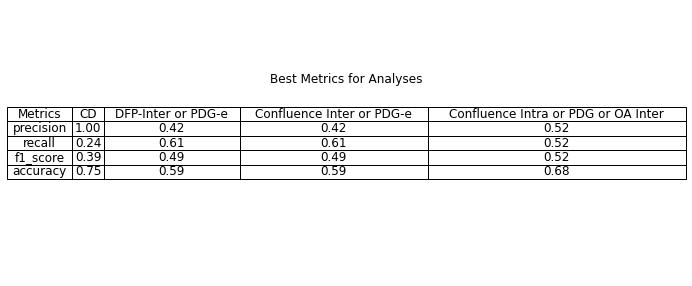

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Dicionário de dados
data = merged_dict

# Criar um DataFrame a partir do dicionário
df = pd.DataFrame(data)

# Criar uma figura vazia
fig, ax = plt.subplots(figsize=(10, 5))

# Desativar os eixos
ax.axis('off')

# Criar uma tabela a partir do DataFrame
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Adicionar um título à tabela

plt.title("Best Metrics for Analyses", y=0.7)

# Ajustar o layout da tabela
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Ajustar o tamanho das colunas com base no texto
table.auto_set_column_width(range(100))

# Salvar a tabela como um arquivo JPG
plt.savefig('tabela.jpg', format='jpg', bbox_inches='tight', dpi=300)

# Mostrar a tabela na tela (opcional)
plt.show()


In [ ]:
def remove_nested_best(best_list) :
    return [i for i in best_list if not any(all(item in i for item in j) for j in best_list if i != j)]

bests_analysis = [to_string_as_set(remove_nested_best(best.mPrecision)), to_string_as_set(remove_nested_best(best.mRecall)),
              to_string_as_set(remove_nested_best(best.mF1)), to_string_as_set(remove_nested_best(best.mAcuracia))]

print(bests_analysis)

["{'right left CD', 'left right CD'}", "{'Confluence Inter', 'right left PDG-e', 'left right PDG-e'} {'right left DFP-Inter', 'left right DFP-Inter', 'right left PDG-e', 'left right PDG-e'}", "{'left right PDG', 'right left PDG', 'Confluence Intra', 'OA Inter'}", "{'right left CD', 'left right CD'}"]


In [ ]:
bests_analysis = [['left right DFP-Inter', 'right left DFP-Inter'], ['left right DFP-Intra', 'right left DFP-Intra'], ['left right CD', 'right left CD'], ['left right CDe', 'right left CDe'], ['left right PDG', 'right left PDG'], ['left right PDG-e', 'right left PDG-e']]

merged_dict = {'Metrics': ['precision', 'recall', 'f1_score', 'accuracy']}

for smaller in bests_analysis:

    if smaller not in list(merged_dict.keys()):
        m_smaller = calculate_matrix(smaller)
        print(smaller)
        actual_dict = best.confusion_matrix(count_fp_fn(m_smaller), smaller)
        l_aux = []
        print(count_fp_fn(m_smaller))
        for m in merged_dict['Metrics']:
            l_aux.append(format(actual_dict[m], '.2f'))

        original_name = sum(get_reverse_name([smaller]), [])
        key = ' or '.join(original_name)
        merged_dict[key] = l_aux 


['left right DFP-Inter', 'right left DFP-Inter']
Precision: 0.32
Recall: 0.27
F1 Score: 0.30
Accuracy: 0.57
['TRUE NEGATIVE: 47', 'FALSE NEGATIVE: 24', 'TRUE POSITIVE: 9', 'FALSE POSITIVE: 19']
['left right DFP-Intra', 'right left DFP-Intra']
Precision: 0.25
Recall: 0.12
F1 Score: 0.16
Accuracy: 0.59
['TRUE NEGATIVE: 54', 'FALSE NEGATIVE: 29', 'TRUE POSITIVE: 4', 'FALSE POSITIVE: 12']
['left right CD', 'right left CD']
Precision: 1.00
Recall: 0.24
F1 Score: 0.39
Accuracy: 0.75
['TRUE NEGATIVE: 66', 'FALSE NEGATIVE: 25', 'TRUE POSITIVE: 8']
['left right CDe', 'right left CDe']
Precision: 0.64
Recall: 0.42
F1 Score: 0.51
Accuracy: 0.73
['FALSE POSITIVE: 8', 'FALSE NEGATIVE: 19', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 58']
['left right PDG', 'right left PDG']
Precision: 0.48
Recall: 0.42
F1 Score: 0.45
Accuracy: 0.66
['FALSE POSITIVE: 15', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 51', 'FALSE NEGATIVE: 19']
['left right PDG-e', 'right left PDG-e']
Precision: 0.46
Recall: 0.58
F1 Score: 0.51
Accu

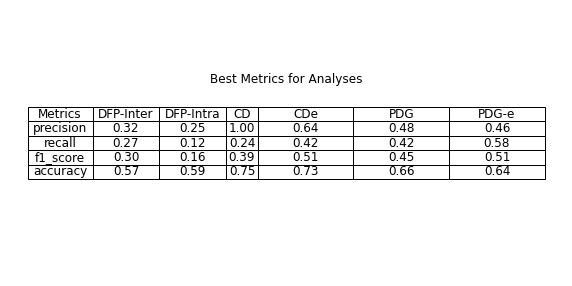

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dicionário de dados
data = merged_dict

# Criar um DataFrame a partir do dicionário
df = pd.DataFrame(data)

# Criar uma figura vazia
fig, ax = plt.subplots(figsize=(10, 5))

# Desativar os eixos
ax.axis('off')

# Criar uma tabela a partir do DataFrame
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Adicionar um título à tabela

plt.title("Best Metrics for Analyses", y=0.7)

# Ajustar o layout da tabela
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Ajustar o tamanho das colunas com base no texto
table.auto_set_column_width([0, 1, 2, 3])

# Salvar a tabela como um arquivo JPG
plt.savefig('tabela_analises.jpg', format='jpg', bbox_inches='tight', dpi=300)

# Mostrar a tabela na tela (opcional)
plt.show()


In [ ]:
data = {
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Value': [round(best.maiorPrecision, 2), round(best.maiorRecall, 2), round(best.maiorF1, 2), round(best.maiorAcuracia, 2)],
   'Analyses': [str(get_reverse_name(best.mPrecision)), 
                str(get_reverse_name(best.mRecall)), 
                str(get_reverse_name(best.mF1)), 
                str(get_reverse_name(best.mAcuracia))]
}
dframe = pd.DataFrame(data)

nome_arquivo = "best_combinations.csv"

dframe.to_csv(nome_arquivo, sep=';', index=False)



In [ ]:
df_t = pd.read_csv('miningframework/output/results/times/resultTime-1.csv', sep=';', encoding='utf-8', on_bad_lines='skip', low_memory=False)


In [ ]:
def sum_n_esimo_element(lista_de_listas, n):
    return sum(sublista[n] for sublista in lista_de_listas)

def get_sum_all_list(all_list):
    return [sum_n_esimo_element(all_list, i) for i in range(len(all_list[0]))]

def get_total_time(list_analysis):
    result = []
    for column_analysis in list_analysis:
        actual_time = [i for i in df_t[column_analysis]]
        result.append(actual_time)
    return result

def get_mean(values):
    return pd.Series(get_sum_all_list(values)).mean()

def get_median(values):
    return pd.Series(get_sum_all_list(values)).median()

def get_sum(values):
    return pd.Series(get_sum_all_list(values)).sum()

def get_standard_desviation(values):
    return pd.Series(get_sum_all_list(values)).std()

In [ ]:
def get_mean_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_mean(result)).sum(), 2)
        metric_t.append(value)
    return metric_t

def get_sum_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_sum(result)).sum(), 2)
        metric_t.append(value)
    return metric_t

def get_median_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_median(result)).sum(), 2)
        metric_t.append(value)
    return metric_t

def get_std_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_standard_desviation(result)).sum(), 2)
        metric_t.append(value)
    return metric_t


In [ ]:
def get_name_analysis_time(list_name, config):
    names = []
    for i in list_name:
        if ("Confluence" in i):
            actual_name = i.replace("Confluence ", "Confluence 1 ")
            if config:
                names.append("Configure Soot "+actual_name)
            names.append("Time to perform "+actual_name)
            
            actual_name = i.replace("Confluence ", "Confluence 2 ")

            if config:
                names.append("Configure Soot "+actual_name)

            names.append("Time to perform "+actual_name)
            
        elif ("left right" in i):
            actual_name = i.replace("left right ", "")
            if ("DF" in i):
                actual_name = actual_name.replace("-", " ")
            else:
                actual_name = actual_name.replace("-", "")

            if config:
                names.append("Configure Soot "+actual_name+" left-right")
                names.append("Configure Soot "+actual_name+" right-left")
            names.append("Time to perform "+actual_name+" left-right")
            names.append("Time to perform "+actual_name+" right-left")
        elif ("right left" not in str(i)):
            if config:
                names.append("Configure Soot "+i)
            names.append("Time to perform "+i)

    return names

In [ ]:

with_config = True

colums = df_t.columns

print("Analyzing", best.mPrecision)
mean_p = get_mean_metric(best.mPrecision, with_config)
median_p = get_median_metric(best.mPrecision, with_config)
# sum_p = get_sum_metric(best.mPrecision, with_config)
std_p = get_std_metric(best.mPrecision, with_config)

# out_precision = f"Mean: {mean_p} Median: {median_p} Sum: {sum_p} Standard: {std_p}"
out_precision = [mean_p, median_p, std_p]

print(out_precision)

print("Analyzing", best.mRecall)
mean_p = get_mean_metric(best.mRecall, with_config)
median_p = get_median_metric(best.mRecall, with_config)
# sum_p = get_sum_metric(best.mRecall, with_config)
std_p = get_std_metric(best.mRecall, with_config)

# out_recall = f"Mean: {mean_p} Median: {median_p} Sum: {sum_p} Standard: {std_p}"
out_recall = [mean_p, median_p, std_p]

print(out_recall)

print("Analyzing", best.mF1)

mean_p = get_mean_metric(best.mF1, with_config)
median_p = get_median_metric(best.mF1, with_config)
# sum_p = get_sum_metric(best.mF1, with_config)
std_p = get_std_metric(best.mF1, with_config)

# out_f1 = f"Mean: {mean_p} Median: {median_p} Sum: {sum_p} Standard: {std_p}"
out_f1 = [mean_p, median_p, std_p]
print(out_f1)

print("Analyzing", best.mAcuracia)
mean_p = get_mean_metric(best.mAcuracia, with_config)
median_p = get_median_metric(best.mAcuracia, with_config)
# sum_p = get_sum_metric(best.mAcuracia, with_config)
std_p = get_std_metric(best.mAcuracia, with_config)

# out_accuracy = f"Mean: {mean_p}\nMedian: {median_p}\nSum: {sum_p}\nStandard: {std_p}\n"
out_accuracy = [mean_p, median_p, std_p]
print(out_accuracy)



Analyzing [['left right CD', 'right left CD']]
[[8.25], [4.53], [11.87]]
Analyzing [['left right PDG-e', 'right left PDG-e', 'Confluence Inter'], ['left right PDG-e', 'right left PDG-e', 'left right DFP-Inter', 'right left DFP-Inter'], ['OA Inter', 'left right PDG-e', 'right left PDG-e', 'Confluence Inter'], ['OA Inter', 'left right PDG-e', 'right left PDG-e', 'left right DFP-Inter', 'right left DFP-Inter'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right DFP-Inter', 'right left DFP-Inter'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right CDe', 'right left CDe'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'Confluence Intra'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right CD', 'right left CD'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right DFP-Intra', 'right left DFP-Intra'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right PDG', 'right left P

In [ ]:
def convert_list_to_tuple(out):
    result = []
    for index in range(len(out[0])):
        val = [x[index] for x in out]
        result.append(tuple(val))
    return result

In [ ]:
data = {
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Value': [round(best.maiorPrecision, 2), round(best.maiorRecall, 2), round(best.maiorF1, 2), round(best.maiorAcuracia, 2)],
    'Analyses': [get_reverse_name(best.mPrecision), get_reverse_name(best.mRecall), get_reverse_name(best.mF1), get_reverse_name(best.mAcuracia)],
    'Time (s) (mean, median, standard)': [convert_list_to_tuple(out_precision), convert_list_to_tuple(out_recall), convert_list_to_tuple(out_f1), convert_list_to_tuple(out_accuracy)]
}

dframe = pd.DataFrame(data)

nome_arquivo = "best_combinations_time.csv"

dframe.to_csv(nome_arquivo, sep=';', index=False)

